# Process bulk counts table

1. Annotate columns (samples) in a way that time point and replicate are annotated
2. Remove rRNA genes
3. Perform TPM normalization and alternatively also raw counts

In [1]:
# Use miniconda environment Jupyter_new for running this notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from tools import *
import warnings
warnings.filterwarnings('ignore')

## 1 Load the dataset and annotation

In [2]:
bulkPath = '../nf_output/countData/countData.tsv'
metaPath = '../SraRunTable.csv' # metadata from SRA
gffPath = '../nf_output/alignments/dualGenome.gff3' # output from nf pipeline

In [3]:
# Load and filter data
df_initial = pd.read_csv(bulkPath, sep = '\t', comment='#', index_col=0)
#df_initial.drop(columns=[f"SRR277237{i:02d}_sorted.bam" for i in range(28, 40)], inplace=True)
metadata = pd.read_csv(metaPath)
#metadata = metadata[metadata['cell_state'] == 'exponential']

In [4]:
df_initial

,Chr,Start,End,Strand,Length,SRR17374249_sorted.bam,SRR17374246_sorted.bam,SRR17374247_sorted.bam,SRR17374244_sorted.bam,SRR17374248_sorted.bam,SRR17374245_sorted.bam,SRR17374241_sorted.bam,SRR17374243_sorted.bam,SRR17374242_sorted.bam
Geneid,,,,,,,,,,,,,,
gene-LUU82_00010,CP089586.1,1,1662,+,1662,460,737,706,694,652,621,669,759,653
gene-LUU82_00015,CP089586.1,1678,2865,+,1188,415,559,581,564,538,530,544,517,552
gene-LUU82_00020,CP089586.1,2849,3586,+,738,283,452,403,468,449,431,463,443,380
gene-LUU82_00025,CP089586.1,3610,4755,+,1146,211,301,316,263,313,312,332,309,342
gene-LUU82_00035,CP089586.1,5048,5332,+,285,82,130,165,120,124,141,150,136,150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-SAM1_00229,MT338525.1,145833,146156,+,324,18880,10745,21853,10135,25516,10986,30655,24716,25818
gene-SAM1_00230,MT338525.1,146256,146492,+,237,11698,6769,13906,7112,16159,7082,17266,13920,14502
gene-SAM1_00231,MT338525.1,146572,147042,+,471,31821,20759,36888,18668,42474,19249,46234,38005,39463


In [5]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 20)
metadata

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time
0,SRR17374241,RNA-Seq,300,13800805200,PRJNA792994,SAMN24493649,5839889528,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548519,Illumina HiSeq 4000,GSM5764204,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:22:00Z,1,GSM5764204,Staphylococcus phage SAM1,SRP352811,45 mins
1,SRR17374242,RNA-Seq,300,15990695400,PRJNA792994,SAMN24493650,6742218415,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548518,Illumina HiSeq 4000,GSM5764203,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:25:00Z,1,GSM5764203,Staphylococcus phage SAM1,SRP352811,45 mins
2,SRR17374243,RNA-Seq,300,14015065500,PRJNA792994,SAMN24493651,5899820388,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548517,Illumina HiSeq 4000,GSM5764202,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:07:00Z,1,GSM5764202,Staphylococcus phage SAM1,SRP352811,45 mins
3,SRR17374244,RNA-Seq,300,12903186600,PRJNA792994,SAMN24493652,5419038065,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548516,Illumina HiSeq 4000,GSM5764201,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:22:00Z,1,GSM5764201,Staphylococcus phage SAM1,SRP352811,35 mins
4,SRR17374245,RNA-Seq,300,13305926400,PRJNA792994,SAMN24493653,5649180438,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548515,Illumina HiSeq 4000,GSM5764200,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:21:00Z,1,GSM5764200,Staphylococcus phage SAM1,SRP352811,35 mins
5,SRR17374246,RNA-Seq,300,11961414600,PRJNA792994,SAMN24493654,5061577595,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548514,Illumina HiSeq 4000,GSM5764199,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:04:00Z,1,GSM5764199,Staphylococcus phage SAM1,SRP352811,35 mins
6,SRR17374247,RNA-Seq,300,11710998000,PRJNA792994,SAMN24493655,4980277700,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548513,Illumina HiSeq 4000,GSM5764198,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:16:00Z,1,GSM5764198,Staphylococcus phage SAM1,SRP352811,15 mins
7,SRR17374248,RNA-Seq,300,12945217500,PRJNA792994,SAMN24493656,5481307927,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548512,Illumina HiSeq 4000,GSM5764197,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:16:00Z,1,GSM5764197,Staphylococcus phage SAM1,SRP352811,15 mins
8,SRR17374249,RNA-Seq,300,10450439100,PRJNA792994,SAMN24493657,4445783773,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548511,Illumina HiSeq 4000,GSM5764196,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:14:00Z,1,GSM5764196,Staphylococcus phage SAM1,SRP352811,15 mins


## 2 Format the dataset

### 2.1 Annotate sample names

Issue now is that the metadata does not properly annotate sample names. Thus, this will be done manually by adding another sample name column to the metadata.

In [6]:
# Match GSM IDs and SampleNames inferred from GEO

sampleDict = {'GSM5764196': '15_R1', 'GSM5764197': '15_R2', 'GSM5764198': '15_R3',
              'GSM5764199': '35_R1', 'GSM5764200': '35_R2', 'GSM5764201': '35_R3',
              'GSM5764202': '45_R1', 'GSM5764203': '45_R2', 'GSM5764204': '45_R3'
}

In [7]:
metadataFull = annotateData(metadata, sampleDict)

In [8]:
metadata.head(1)

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time
0,SRR17374241,RNA-Seq,300,13800805200,PRJNA792994,SAMN24493649,5839889528,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548519,Illumina HiSeq 4000,GSM5764204,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:22:00Z,1,GSM5764204,Staphylococcus phage SAM1,SRP352811,45 mins


In [9]:
metadataFull.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,Center Name,Consent,DATASTORE filetype,DATASTORE provider,DATASTORE region,Experiment,Instrument,Library Name,LibraryLayout,LibrarySelection,LibrarySource,Organism,Platform,ReleaseDate,create_date,version,Sample Name,source_name,SRA Study,time,SampleID,SampleNames
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SRR17374241_sorted.bam,SRR17374241,RNA-Seq,300,13800805200,PRJNA792994,SAMN24493649,5839889528,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548519,Illumina HiSeq 4000,GSM5764204,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:22:00Z,1,GSM5764204,Staphylococcus phage SAM1,SRP352811,45 mins,SRR17374241_sorted.bam,45_R3
SRR17374242_sorted.bam,SRR17374242,RNA-Seq,300,15990695400,PRJNA792994,SAMN24493650,6742218415,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548518,Illumina HiSeq 4000,GSM5764203,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:25:00Z,1,GSM5764203,Staphylococcus phage SAM1,SRP352811,45 mins,SRR17374242_sorted.bam,45_R2
SRR17374243_sorted.bam,SRR17374243,RNA-Seq,300,14015065500,PRJNA792994,SAMN24493651,5899820388,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548517,Illumina HiSeq 4000,GSM5764202,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:07:00Z,1,GSM5764202,Staphylococcus phage SAM1,SRP352811,45 mins,SRR17374243_sorted.bam,45_R1
SRR17374244_sorted.bam,SRR17374244,RNA-Seq,300,12903186600,PRJNA792994,SAMN24493652,5419038065,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548516,Illumina HiSeq 4000,GSM5764201,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:22:00Z,1,GSM5764201,Staphylococcus phage SAM1,SRP352811,35 mins,SRR17374244_sorted.bam,35_R3
SRR17374245_sorted.bam,SRR17374245,RNA-Seq,300,13305926400,PRJNA792994,SAMN24493653,5649180438,"3.36, APC MICROBIOME IRELAND, UNIVERSITY COLLE...",public,"fastq,run.zq,sra","gs,ncbi,s3","gs.us-east1,ncbi.public,s3.us-east-1",SRX13548515,Illumina HiSeq 4000,GSM5764200,PAIRED,cDNA,TRANSCRIPTOMIC,Staphylococcus phage SAM1,ILLUMINA,2022-03-30T00:00:00Z,2021-12-29T11:21:00Z,1,GSM5764200,Staphylococcus phage SAM1,SRP352811,35 mins,SRR17374245_sorted.bam,35_R2


Add correct sample names.

In [10]:
df = changeColnames(df_initial.iloc[:,5:df_initial.shape[1]], metadataFull)
df = df[['15_R1', '15_R2', '15_R3', 
         '35_R1', '35_R2', '35_R3', 
         '45_R1', '45_R2', '45_R3']]
df.head()

SampleNames,15_R1,15_R2,15_R3,35_R1,35_R2,35_R3,45_R1,45_R2,45_R3
Geneid,,,,,,,,,
gene-LUU82_00010,460,652,706,737,621,694,759,653,669
gene-LUU82_00015,415,538,581,559,530,564,517,552,544
gene-LUU82_00020,283,449,403,452,431,468,443,380,463
gene-LUU82_00025,211,313,316,301,312,263,309,342,332
gene-LUU82_00035,82,124,165,130,141,120,136,150,150


### 2.2 Remove rRNA genes

Consult gff3 file to get rRNA geneids.

In [11]:
# Load gff3 and split into genes and CDS dfs
gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3.columns=["seq_id", "source", "type", "start", "end", "phase", "strand", "score", "attributes"]
gff3_genes = gff3.loc[gff3["type"] == 'gene']

# Column formating for genes
gff3_genes = gff3_genes.reset_index(drop=True)
dct_genes = gff3_genes["attributes"].str.split(';').apply(lambda items: dict(item.split('=', 1) for item in items if '=' in item))
cols_to_keep = ['ID', 'Name', 'gbkey', 'gene_biotype', 'locus_tag', 'gene']
gff3_genes = pd.concat([gff3_genes, pd.json_normalize(dct_genes)[cols_to_keep]], axis=1)

# Generate locus_tag, product dictonary over all different feature types
attrs = gff3["attributes"].str.split(";", expand=True)
attrs_dicts = attrs.apply(lambda row: {item.split("=")[0]: item.split("=")[1] for item in row if "=" in str(item)}, axis=1)
attrs_df = pd.json_normalize(attrs_dicts)
attrs_df = attrs_df.dropna(subset=["locus_tag", "product"])
locus_product_dict = dict(zip(attrs_df["locus_tag"], attrs_df["product"]))

# Add gene product, if not stated in gff3, fill with gene_biotype
gff3_genes["product"] = gff3_genes["locus_tag"].map(locus_product_dict)
# gff3_genes["product"] = gff3_genes["product"].fillna("other")
gff3_genes["product"] = gff3_genes["product"].fillna(gff3_genes["gene_biotype"])

# If gene = NA, take from ID column
gff3_genes["gene"] = gff3_genes["gene"].fillna(gff3_genes["ID"])

# Drop attributes column
gff3_genes = gff3_genes.drop(["attributes"], axis=1)

In [12]:
pharokka_path = "../../../2025-12_reannotation_phage_genomes/Pharokka_proteins_phages_out/MT338525.1_out/pharokka_proteins_full_merged_output.tsv"
gff3_genes = add_pharokka(gff3_genes, pharokka_path)
gff3_genes.loc[gff3_genes['seq_id'] == "MT338525.1"]

,seq_id,source,type,start,end,phase,strand,score,ID,Name,gbkey,gene_biotype,locus_tag,gene,product,annot,PHROG,category
2740,MT338525.1,Genbank,gene,486.0,785.0,.,+,.,gene-SAM1_00001,SAM1_00001,Gene,protein_coding,SAM1_00001,gene-SAM1_00001,hypothetical protein,hypothetical protein,654.0,unknown function
2741,MT338525.1,Genbank,gene,801.0,986.0,.,+,.,gene-SAM1_00002,SAM1_00002,Gene,protein_coding,SAM1_00002,gene-SAM1_00002,hypothetical protein,hypothetical protein,3204.0,unknown function
2742,MT338525.1,Genbank,gene,1093.0,1383.0,.,+,.,gene-SAM1_00003,SAM1_00003,Gene,protein_coding,SAM1_00003,gene-SAM1_00003,hypothetical protein,hypothetical protein,654.0,unknown function
2743,MT338525.1,Genbank,gene,1383.0,1670.0,.,+,.,gene-SAM1_00004,SAM1_00004,Gene,protein_coding,SAM1_00004,gene-SAM1_00004,hypothetical protein,hypothetical protein,654.0,unknown function
2744,MT338525.1,Genbank,gene,1670.0,1963.0,.,+,.,gene-SAM1_00005,SAM1_00005,Gene,protein_coding,SAM1_00005,gene-SAM1_00005,hypothetical protein,hypothetical protein,654.0,unknown function
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,MT338525.1,Genbank,gene,145833.0,146156.0,.,+,.,gene-SAM1_00229,SAM1_00229,Gene,protein_coding,SAM1_00229,gene-SAM1_00229,hypothetical protein,hypothetical protein,3276.0,unknown function
2969,MT338525.1,Genbank,gene,146256.0,146492.0,.,+,.,gene-SAM1_00230,SAM1_00230,Gene,protein_coding,SAM1_00230,gene-SAM1_00230,hypothetical protein,hypothetical protein,3480.0,unknown function
2970,MT338525.1,Genbank,gene,146572.0,147042.0,.,+,.,gene-SAM1_00231,SAM1_00231,Gene,protein_coding,SAM1_00231,gene-SAM1_00231,hypothetical protein,hypothetical protein,2543.0,unknown function
2971,MT338525.1,Genbank,gene,147072.0,147197.0,.,+,.,gene-SAM1_00232,SAM1_00232,Gene,protein_coding,SAM1_00232,gene-SAM1_00232,hypothetical protein,hypothetical protein,7733.0,unknown function


In [13]:
# Load ggf3 file

gff3 = pd.read_csv(gffPath, sep='\t', header = None, skiprows = 5)
gff3 = gff3.loc[gff3.iloc[:,2] == 'gene']

# Format some new columns
gff3['ID'] = pd.DataFrame(gff3.iloc[:,8].str.split('ID=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['GeneType'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene_biotype=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]
gff3['Symbol'] = pd.DataFrame(gff3.iloc[:,8].str.split('gene=', expand = True)).iloc[:,1].str.split(';', expand = True).iloc[:,0]

# Add entity host and phage
gff3['Entity'] = np.where(gff3[0] == 'MT338525.1', 'phage', 'host')
gff3.index = gff3['ID']
rRNAs = gff3.loc[gff3['GeneType'] == 'rRNA', 'ID'].tolist()

In [14]:
gff3

,0,1,2,3,4,5,6,7,8,ID,GeneType,Symbol,Entity
ID,,,,,,,,,,,,,
gene-LUU82_00010,CP089586.1,Genbank,gene,1.0,1662.0,.,+,.,ID=gene-LUU82_00010;Name=LUU82_00010;gbkey=Gen...,gene-LUU82_00010,protein_coding,None,host
gene-LUU82_00015,CP089586.1,Genbank,gene,1678.0,2865.0,.,+,.,ID=gene-LUU82_00015;Name=LUU82_00015;gbkey=Gen...,gene-LUU82_00015,protein_coding,None,host
gene-LUU82_00020,CP089586.1,Genbank,gene,2849.0,3586.0,.,+,.,ID=gene-LUU82_00020;Name=LUU82_00020;gbkey=Gen...,gene-LUU82_00020,protein_coding,None,host
gene-LUU82_00025,CP089586.1,Genbank,gene,3610.0,4755.0,.,+,.,ID=gene-LUU82_00025;Name=LUU82_00025;gbkey=Gen...,gene-LUU82_00025,protein_coding,None,host
gene-LUU82_00035,CP089586.1,Genbank,gene,5048.0,5332.0,.,+,.,ID=gene-LUU82_00035;Name=LUU82_00035;gbkey=Gen...,gene-LUU82_00035,protein_coding,None,host
...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-SAM1_00229,MT338525.1,Genbank,gene,145833.0,146156.0,.,+,.,ID=gene-SAM1_00229;Name=SAM1_00229;gbkey=Gene;...,gene-SAM1_00229,protein_coding,None,phage
gene-SAM1_00230,MT338525.1,Genbank,gene,146256.0,146492.0,.,+,.,ID=gene-SAM1_00230;Name=SAM1_00230;gbkey=Gene;...,gene-SAM1_00230,protein_coding,None,phage
gene-SAM1_00231,MT338525.1,Genbank,gene,146572.0,147042.0,.,+,.,ID=gene-SAM1_00231;Name=SAM1_00231;gbkey=Gene;...,gene-SAM1_00231,protein_coding,None,phage


Perform in silico rRNA depletion.

In [15]:
df_norRNAs = rRNAdepletion(df,rRNAs)
df_norRNAs.head()

SampleNames,15_R1,15_R2,15_R3,35_R1,35_R2,35_R3,45_R1,45_R2,45_R3
Geneid,,,,,,,,,
gene-LUU82_10270,2286,2987,2954,1498,3199,3313,2439,3120,2709
gene-LUU82_03285,3111,4611,4619,3363,4607,4910,3888,5257,4629
gene-LUU82_02245,1808,2697,2246,2349,2762,3182,2310,2931,2531
gene-LUU82_01550,2346,4035,3143,3466,4122,4855,3633,4500,4323
gene-LUU82_06715,3041,4251,3588,3416,3403,4175,2713,3814,3434


### 2.3 Read count normalization

Important note: gene symbols not available for most genes.

In [16]:
# Function to fill in missing symbols by geneid.

def fillSymbols(df):
    df_new = df.copy()
    index = df.index.to_list()
    for i in range(0,df.shape[0]):
        if (df.iloc[i,-1:].values == None):
            df_new.iloc[i,-1:] = index[i]
    return df_new

Convert counts to TPM.

In [17]:
tpms = TPM(df_norRNAs, df_initial, 0.5)
tpms['Entity'] = gff3.loc[sorted(tpms.index.to_list()), 'Entity']
tpms['Symbol'] = gff3.loc[sorted(tpms.index.to_list()), 'Symbol']

tpms = fillSymbols(tpms)
tpms = make_unique_with_index(tpms)
tpms

SampleNames,15_R1,15_R2,15_R3,35_R1,35_R2,35_R3,45_R1,45_R2,45_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-LUU82_10270,38.985453,38.186666,43.684162,23.726180,43.244043,44.951132,30.520138,35.325681,34.446663,host,gene-LUU82_10270
gene-LUU82_03285,82.553978,91.723974,106.284959,82.870379,96.905034,103.661191,75.701520,92.615240,91.585963,host,gene-LUU82_03285
gene-LUU82_02245,69.762408,78.007588,75.148101,84.162396,84.473022,97.677299,65.397812,75.080615,72.812762,host,gene-LUU82_02245
gene-LUU82_01550,46.241673,59.618738,53.719886,63.437181,64.400085,76.132347,52.540287,58.885548,63.529446,host,gene-LUU82_01550
gene-LUU82_06715,53.536676,56.101983,54.775351,55.845052,47.489996,58.478248,35.046746,44.579601,45.076868,host,gene-LUU82_06715
...,...,...,...,...,...,...,...,...,...,...,...
gene-LUU82_10665,0.955507,1.157130,1.848404,0.614289,1.223552,1.345056,0.808976,0.927212,0.822069,host,gene-LUU82_10665
gene-LUU82_06810,106.629234,116.402447,116.169106,146.745456,145.815463,144.220458,118.427672,138.221571,132.921607,host,gene-LUU82_06810
gene-LUU82_00615,65.901621,47.381543,69.660127,94.992014,77.418907,76.946549,99.537661,99.343715,100.034073,host,gene-LUU82_00615


In [18]:
# Check gene names unique
len(tpms['Symbol'].unique())

2954

Log2+1 normalization raw counts

In [19]:
logs = logNorm(df_norRNAs)
logs['Entity'] = gff3.loc[sorted(logs.index.to_list()), 'Entity']
logs['Symbol'] = gff3.loc[sorted(logs.index.to_list()), 'Symbol']
logs = fillSymbols(logs)
# Make gene names unique
logs = make_unique_with_index(logs)
logs

SampleNames,15_R1,15_R2,15_R3,35_R1,35_R2,35_R3,45_R1,45_R2,45_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-LUU82_10270,11.159241,11.544964,11.528942,10.549785,11.643856,11.694358,11.252665,11.607793,11.404077,host,gene-LUU82_10270
gene-LUU82_03285,11.603626,12.171177,12.173677,11.715962,12.169925,12.261801,11.925184,12.360298,12.176796,host,gene-LUU82_03285
gene-LUU82_02245,10.820977,11.397675,11.133784,11.198445,11.432020,11.636171,11.174302,11.517669,11.306062,host,gene-LUU82_02245
gene-LUU82_01550,11.196602,11.978710,11.618386,11.759472,12.009479,12.245553,11.827343,12.136030,12.078151,host,gene-LUU82_01550
gene-LUU82_06715,11.570804,12.053926,11.809366,11.738515,11.733015,12.027906,11.406205,11.897467,11.746094,host,gene-LUU82_06715
...,...,...,...,...,...,...,...,...,...,...,...
gene-LUU82_10665,2.807355,3.459432,3.906891,2.321928,3.459432,3.584963,3.000000,3.321928,3.000000,host,gene-LUU82_10665
gene-LUU82_06810,11.597121,12.139232,11.926296,12.164593,12.383704,12.362492,12.195065,12.562242,12.338458,host,gene-LUU82_06810
gene-LUU82_00615,11.632541,11.572227,11.918118,12.266787,12.199979,12.185805,12.673972,12.815383,12.657988,host,gene-LUU82_00615


Log2+1 normalization tpms

In [20]:
logTPMs = logNorm(tpms.iloc[:, :-2])
logTPMs = logTPMs.join(tpms.iloc[:, -2:])
logTPMs = fillSymbols(logTPMs)
# Make gene names unique
logTPMs = make_unique_with_index(logTPMs)
logTPMs

SampleNames,15_R1,15_R2,15_R3,35_R1,35_R2,35_R3,45_R1,45_R2,45_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-LUU82_10270,5.321403,5.292291,5.481692,4.627967,5.467411,5.522028,4.978202,5.182918,5.147578,host,gene-LUU82_10270
gene-LUU82_03285,6.384637,6.534870,6.745304,6.390089,6.613311,6.709583,6.261183,6.548672,6.532722,host,gene-LUU82_03285
gene-LUU82_02245,6.144911,6.303919,6.250736,6.412145,6.417397,6.624646,6.053064,6.249457,6.205798,host,gene-LUU82_02245
gene-LUU82_01550,5.561988,5.921692,5.773993,6.009821,6.031221,6.269264,5.742553,5.904136,6.011886,host,gene-LUU82_01550
gene-LUU82_06715,5.769155,5.835469,5.801556,5.828963,5.599615,5.894290,5.171797,5.510316,5.525971,host,gene-LUU82_06715
...,...,...,...,...,...,...,...,...,...,...,...
gene-LUU82_10665,0.967542,1.109113,1.510154,0.690899,1.152866,1.229623,0.855174,0.946515,0.865578,host,gene-LUU82_10665
gene-LUU82_06810,6.749926,6.875319,6.872448,7.206970,7.197860,7.182101,6.899993,7.121239,7.065245,host,gene-LUU82_06810
gene-LUU82_00615,6.063969,5.596385,6.142824,6.584842,6.293130,6.284413,6.651592,6.648806,6.658698,host,gene-LUU82_00615


## 3 Filter samples, if necessary

Look for outliers visually by PCA.

In [21]:
columnOrder = ['15_R1', '15_R2', '15_R3', 
               '35_R1', '35_R2', '35_R3', 
               '45_R1', '45_R2', '45_R3']

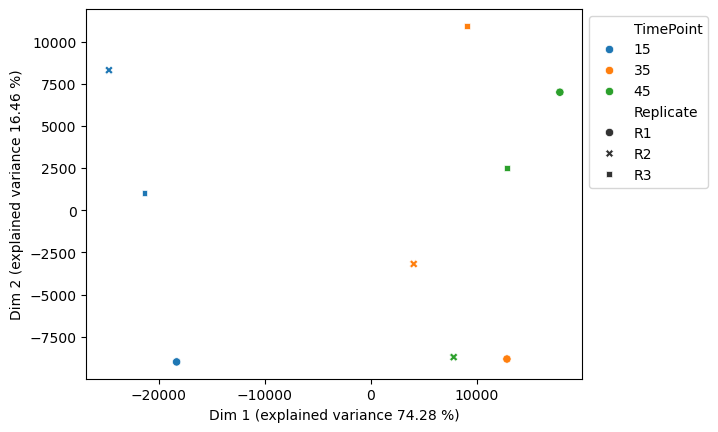

In [22]:
txPCA(tpms[columnOrder])

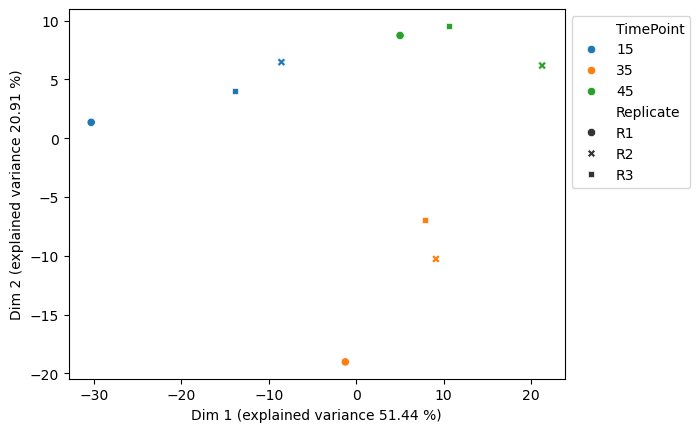

In [23]:
txPCA(logs[columnOrder])

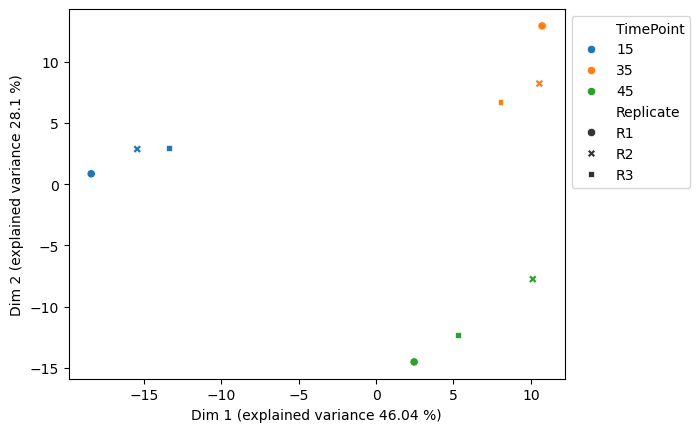

In [24]:
txPCA(logTPMs[columnOrder])

In [25]:
tpmHost = tpms[tpms['Entity'] == 'host']
tpmPhage = tpms[tpms['Entity'] == 'phage']
logTPMsHost = logTPMs[logTPMs['Entity'] == 'host']
logTPMsPhage = logTPMs[logTPMs['Entity'] == 'phage']

tpmHost

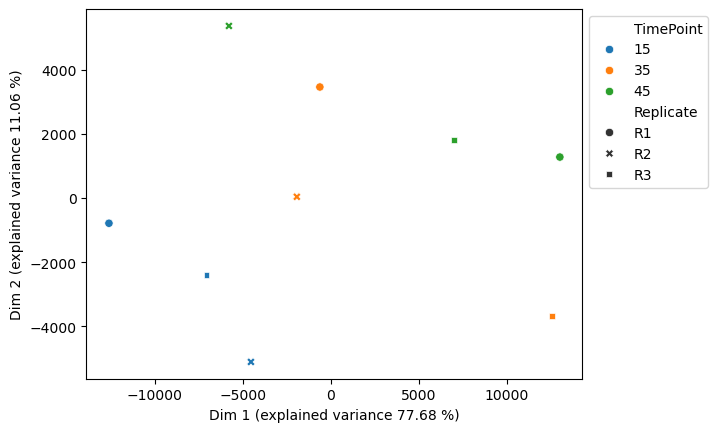

In [26]:
txPCA(tpmHost[columnOrder])

tpmPhage

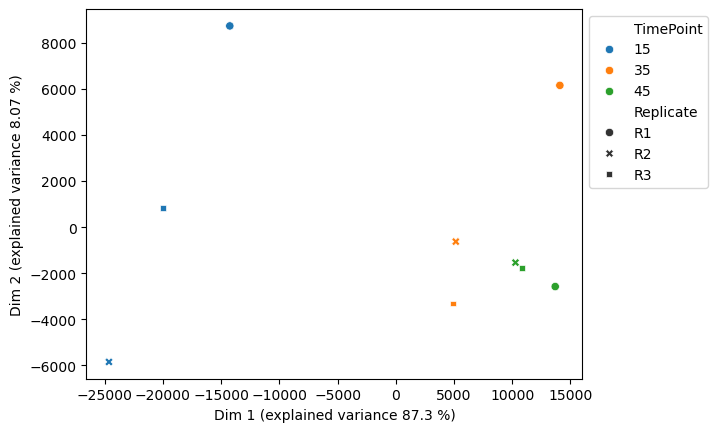

In [27]:
txPCA(tpmPhage[columnOrder])

logTPM Host

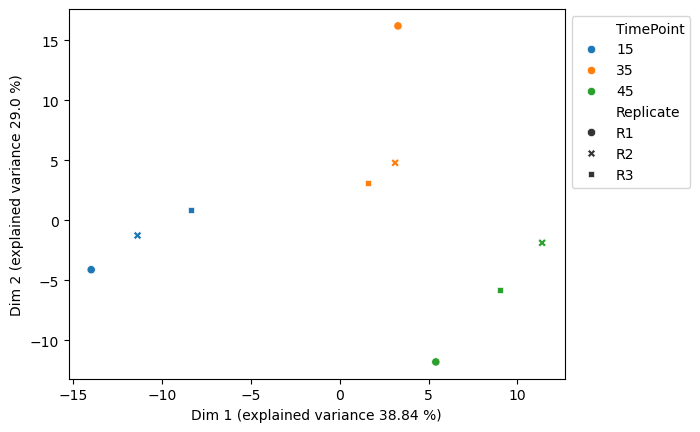

In [28]:
txPCA(logTPMsHost[columnOrder])

logTPM Phage

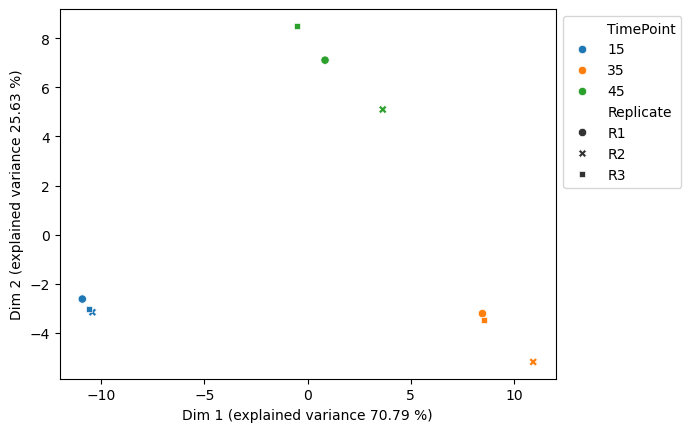

In [29]:
txPCA(logTPMsPhage[columnOrder])

$\rightarrow$ Looks fine.

## 4. Final grouping

Summarize time points with mean and standard deviation for TPM-normalized data.

In [30]:
TPMmeans, TPMsds = getMeanSD(tpms[columnOrder])
TPMmeans = TPMmeans[['15', '35', '45']]
TPMmeans[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMmeans

,15,35,45,Entity,Symbol
Geneid,,,,,
gene-LUU82_10270,40.285427,37.307118,33.430827,host,gene-LUU82_10270
gene-LUU82_03285,93.520970,94.478868,86.634241,host,gene-LUU82_03285
gene-LUU82_02245,74.306032,88.770906,71.097063,host,gene-LUU82_02245
gene-LUU82_01550,53.193432,67.989871,58.318427,host,gene-LUU82_01550
gene-LUU82_06715,54.804670,53.937765,41.567738,host,gene-LUU82_06715
...,...,...,...,...,...
gene-LUU82_10665,1.320347,1.060966,0.852752,host,gene-LUU82_10665
gene-LUU82_06810,113.066929,145.593792,129.856950,host,gene-LUU82_06810
gene-LUU82_00615,60.981097,83.119157,99.638483,host,gene-LUU82_00615


In [31]:
TPMsds = TPMsds[['15', '35', '45']]
TPMsds[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
TPMsds

,15,35,45,Entity,Symbol
Geneid,,,,,
gene-LUU82_10270,2.425293,9.628428,2.089219,host,gene-LUU82_10270
gene-LUU82_03285,9.771106,8.659452,7.742013,host,gene-LUU82_03285
gene-LUU82_02245,3.418339,6.299048,4.134964,host,gene-LUU82_02245
gene-LUU82_01550,5.473837,5.771004,4.504192,host,gene-LUU82_01550
gene-LUU82_06715,1.047488,4.684281,4.615504,host,gene-LUU82_06715
...,...,...,...,...,...
gene-LUU82_10665,0.382358,0.319720,0.052921,host,gene-LUU82_10665
gene-LUU82_06810,4.553135,1.042675,8.366349,host,gene-LUU82_06810
gene-LUU82_00615,9.737984,8.397592,0.290715,host,gene-LUU82_00615


In [32]:
propExp = proportionalExp(TPMmeans[['15', '35', '45']])
propExp[['Entity', 'Symbol']] = TPMmeans[['Entity', 'Symbol']]
propExp

,15,35,45,Entity,Symbol
Geneid,,,,,
gene-LUU82_10270,1.000000,0.926070,0.829849,host,gene-LUU82_10270
gene-LUU82_03285,0.989861,1.000000,0.916970,host,gene-LUU82_03285
gene-LUU82_02245,0.837054,1.000000,0.800905,host,gene-LUU82_02245
gene-LUU82_01550,0.782373,1.000000,0.857752,host,gene-LUU82_01550
gene-LUU82_06715,1.000000,0.984182,0.758471,host,gene-LUU82_06715
...,...,...,...,...,...
gene-LUU82_10665,1.000000,0.803551,0.645855,host,gene-LUU82_10665
gene-LUU82_06810,0.776592,1.000000,0.891913,host,gene-LUU82_06810
gene-LUU82_00615,0.612024,0.834207,1.000000,host,gene-LUU82_00615


## 5. Phage gene classification

In [33]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelThreshold(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-2)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM*0.2

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x >= thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassThreshold'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassThreshold'] = 'None'

    return tpmOut

In [34]:
# Add a classification label based on exceeding 20 % of maximal expression

def classLabelMax(tpm):
    
    labels = list()
    
    i = 0
    while i < tpm.shape[0]:

        # Get array of expression values at time points
        expressions = list(tpm.iloc[i,0:(tpm.shape[1]-3)])

        # Get maximal value for each gene across time points
        maxTPM = max(expressions)

        # Get the threshold value
        thresHold = maxTPM

        # Subset expressions based on threshold
        filteredExpressions = [x for x in expressions if x == thresHold]

        # Get index of time point
        indices = [expressions.index(x) for x in filteredExpressions]
        timePoint = min(indices)

        if timePoint == 0:
            labels.append('early')
        elif timePoint == 1:
            labels.append('middle')
        elif timePoint == 2:
            labels.append('late')

        i += 1

    tpmOut = tpm.copy()
    tpmOut['ClassMax'] = labels
    tpmOut.loc[tpmOut['Entity'] == 'host', 'ClassMax'] = 'None'

    return tpmOut

In [35]:
TPMmeans

,15,35,45,Entity,Symbol
Geneid,,,,,
gene-LUU82_10270,40.285427,37.307118,33.430827,host,gene-LUU82_10270
gene-LUU82_03285,93.520970,94.478868,86.634241,host,gene-LUU82_03285
gene-LUU82_02245,74.306032,88.770906,71.097063,host,gene-LUU82_02245
gene-LUU82_01550,53.193432,67.989871,58.318427,host,gene-LUU82_01550
gene-LUU82_06715,54.804670,53.937765,41.567738,host,gene-LUU82_06715
...,...,...,...,...,...
gene-LUU82_10665,1.320347,1.060966,0.852752,host,gene-LUU82_10665
gene-LUU82_06810,113.066929,145.593792,129.856950,host,gene-LUU82_06810
gene-LUU82_00615,60.981097,83.119157,99.638483,host,gene-LUU82_00615


In [36]:
TPMmeans = classLabelThreshold(TPMmeans)
TPMmeans = classLabelMax(TPMmeans)

In [37]:
pd.set_option('display.max_rows', 20)
TPMmeans[TPMmeans['Entity'] == 'phage'].sort_index()

,15,35,45,Entity,Symbol,ClassThreshold,ClassMax
Geneid,,,,,,,
gene-SAM1_00001,203.028215,80.163870,229.509893,phage,gene-SAM1_00001,early,late
gene-SAM1_00002,238.393466,95.588265,265.488490,phage,gene-SAM1_00002,early,late
gene-SAM1_00003,129.655178,56.913040,187.967387,phage,gene-SAM1_00003,early,late
gene-SAM1_00004,178.783166,69.471108,244.783145,phage,gene-SAM1_00004,early,late
gene-SAM1_00005,227.212433,92.600764,315.245728,phage,gene-SAM1_00005,early,late
...,...,...,...,...,...,...,...
gene-SAM1_00229,956.203758,449.088516,975.937916,phage,gene-SAM1_00229,early,late
gene-SAM1_00230,823.251780,402.987457,750.856964,phage,gene-SAM1_00230,early,early
gene-SAM1_00231,1104.580223,570.355000,1022.709837,phage,gene-SAM1_00231,early,early


In [38]:
TPMmeans[TPMmeans['Entity'] == 'phage']['ClassMax'].value_counts()

ClassMax
early     149
late       74
middle     10
Name: count, dtype: int64

Add classes to other dfs.

In [39]:
TPMsds[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
tpms[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
logs[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]
propExp[['ClassThreshold', 'ClassMax']] = TPMmeans[['ClassThreshold', 'ClassMax']]

# gff3
gff3_final = gff3_genes.merge(TPMmeans[["ClassThreshold", "ClassMax"]], right_index=True, left_on="ID", how="left")
gff3_host  = gff3_final[(gff3_final['seq_id'] == 'CP089586.1') | (gff3_final['seq_id'] == 'CP089587.1')]
gff3_phage = gff3_final[gff3_final['seq_id'] == 'MT338525.1']

## 6. Add variance to all dataframes

Base variance call on tpms.

In [40]:
def stabilizedVariance(df):
    labels = list()
    
    i = 0
    while i < df.shape[0]:

        # Get array of expression values at time points
        expressions = list(df.iloc[i,0:(df.shape[1]-4)])

        # Get mean expression for the gene
        exprMean = np.mean(np.array(expressions))

        # Get the variance for the gene
        varGene = np.var(np.array(expressions))

        # Stabilized variance
        stableVarGene = varGene/exprMean

        labels.append(stableVarGene)

        i += 1

    tpmOut = df.copy()
    tpmOut['Variance'] = labels

    return tpmOut

In [41]:
tpms = stabilizedVariance(tpms)
tpms

SampleNames,15_R1,15_R2,15_R3,35_R1,35_R2,35_R3,45_R1,45_R2,45_R3,Entity,Symbol,ClassThreshold,ClassMax,Variance
Geneid,,,,,,,,,,,,,,
gene-LUU82_10270,38.985453,38.186666,43.684162,23.726180,43.244043,44.951132,30.520138,35.325681,34.446663,host,gene-LUU82_10270,None,None,1.140126
gene-LUU82_03285,82.553978,91.723974,106.284959,82.870379,96.905034,103.661191,75.701520,92.615240,91.585963,host,gene-LUU82_03285,None,None,0.972301
gene-LUU82_02245,69.762408,78.007588,75.148101,84.162396,84.473022,97.677299,65.397812,75.080615,72.812762,host,gene-LUU82_02245,None,None,1.049473
gene-LUU82_01550,46.241673,59.618738,53.719886,63.437181,64.400085,76.132347,52.540287,58.885548,63.529446,host,gene-LUU82_01550,None,None,1.094516
gene-LUU82_06715,53.536676,56.101983,54.775351,55.845052,47.489996,58.478248,35.046746,44.579601,45.076868,host,gene-LUU82_06715,None,None,1.024577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gene-LUU82_10665,0.955507,1.157130,1.848404,0.614289,1.223552,1.345056,0.808976,0.927212,0.822069,host,gene-LUU82_10665,None,None,0.111617
gene-LUU82_06810,106.629234,116.402447,116.169106,146.745456,145.815463,144.220458,118.427672,138.221571,132.921607,host,gene-LUU82_06810,None,None,1.598376
gene-LUU82_00615,65.901621,47.381543,69.660127,94.992014,77.418907,76.946549,99.537661,99.343715,100.034073,host,gene-LUU82_00615,None,None,3.765880


In [42]:
logs['Variance'] = tpms['Variance']
TPMmeans['Variance'] = tpms['Variance']
TPMsds['Variance'] = tpms['Variance']
propExp['Variance'] = tpms['Variance']

## 7. Write data to output

In [43]:
df_norRNAs[['Entity', 'Symbol']] = tpms[['Entity', 'Symbol']]
df_norRNAs

SampleNames,15_R1,15_R2,15_R3,35_R1,35_R2,35_R3,45_R1,45_R2,45_R3,Entity,Symbol
Geneid,,,,,,,,,,,
gene-LUU82_10270,2286,2987,2954,1498,3199,3313,2439,3120,2709,host,gene-LUU82_10270
gene-LUU82_03285,3111,4611,4619,3363,4607,4910,3888,5257,4629,host,gene-LUU82_03285
gene-LUU82_02245,1808,2697,2246,2349,2762,3182,2310,2931,2531,host,gene-LUU82_02245
gene-LUU82_01550,2346,4035,3143,3466,4122,4855,3633,4500,4323,host,gene-LUU82_01550
gene-LUU82_06715,3041,4251,3588,3416,3403,4175,2713,3814,3434,host,gene-LUU82_06715
...,...,...,...,...,...,...,...,...,...,...,...
gene-LUU82_10665,6,10,14,4,10,11,7,9,7,host,gene-LUU82_10665
gene-LUU82_06810,3097,4510,3891,4590,5343,5265,4688,6047,5178,host,gene-LUU82_06810
gene-LUU82_00615,3174,3044,3869,4927,4704,4658,6534,7207,6462,host,gene-LUU82_00615


In [44]:
# Full TPM table
tpms.to_csv('Buttimer_full_TPM.tsv', sep = '\t')
# Full raw_counts table
df_norRNAs.to_csv('Buttimer_full_raw_counts.tsv', sep = '\t')
# Summarized (time point means) TPM table
TPMmeans.to_csv('Buttimer_TPM_means.tsv', sep = '\t')
# Summarized (time point) TPM standard deviation
TPMsds.to_csv('Buttimer_TPM_std.tsv', sep = '\t')
# Proportional expression per gene and time point
propExp.to_csv('Buttimer_fractional_expression.tsv', sep = '\t')
# Processed gff3 file
gff3_host.to_csv('Buttimer_host_gff3.tsv', sep='\t')
gff3_phage.to_csv('Buttimer_phage_gff3.tsv', sep='\t')